Topics Covered:
* Data Cleaning (removing puntuation, lower case and so on, Lemmatization)
* Sentiment Analysis
* Topic Modeling using NMF with Tf-IDF
* PCA
* News topic changes over time (used Tableu to visualize)
* Supervised learning with Random Forests



In [1]:
import sqlite3


In [1]:
import pandas as pd

In [ ]:
#client = MongoClient()
#client.database_names()
#news_db = client.NEWS
#news_db.collection_names()
#articles = news_db.publications
#cursor = articles.find({'year' : 2016})
#result = list(cursor)
#news_df_2016 = pd.DataFrame(result)


In [3]:
conn = sqlite3.connect('/Users/aminenhila/Desktop/Metis/Project4/Data_Code/all-the-news.db')


In [5]:
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

longform


In [6]:
query = conn.execute("SELECT * From longform")
cols = [column[0] for column in query.description]
results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

In [7]:
# take only 2016 and 2017 years
news_df_2017_2016_all = results[(results.year == 2017) | (results.year == 2016)]

In [8]:
news_df_2017_2016_all.shape

(171031, 12)

In [9]:
news_df_2017_2016_all.publication.value_counts()

New York Times         25286
Breitbart              23716
New York Post          18096
Reuters                15022
NPR                    11828
Washington Post        11589
Buzzfeed News          10699
Guardian                9812
Business Insider        8344
CNN                     7943
Atlantic                7385
National Review         6226
Vox                     4882
Fox News                4351
Talking Points Memo     2568
Los Angeles Times       2542
New Inquiry              464
Verge                    278
Name: publication, dtype: int64

In [11]:
news_df_2017_2016 = news_df_2017_2016_all[(news_df_2017_2016_all.publication=='Reuters') |
                            (news_df_2017_2016_all.publication=='Fox') |
                            (news_df_2017_2016_all.publication=='New York Times')|
                            (news_df_2017_2016_all.publication=='Breitbart')|
                            (news_df_2017_2016_all.publication== 'CNN')|
                            (news_df_2017_2016_all.publication=='Business Insider')|
                            (news_df_2017_2016_all.publication=='Atlantic')|
                            (news_df_2017_2016_all.publication=='Buzzfeed News')|
                            (news_df_2017_2016_all.publication=='National Review')|
                            (news_df_2017_2016_all.publication=='New York Post')|
                            (news_df_2017_2016_all.publication=='Guardian')|
                            (news_df_2017_2016_all.publication=='NPR')|
                            (news_df_2017_2016_all.publication=='Vox')|
                            (news_df_2017_2016_all.publication=='Washington Post')]

In [13]:
news_df_2017_2016.shape

(160828, 12)

In [14]:
news_df_2017_2016 = news_df_2017_2016.drop(['section', 'url'], axis = 1)

In [16]:
news_df_2017_2016 = news_df_2017_2016.drop(['category', 'digital', 'author'], axis = 1)

In [17]:
news_df_2017_2016.head()

,id,title,date,content,year,month,publication
10230,17283,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016,12,New York Times
10231,17284,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017,6,New York Times
10232,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017,1,New York Times
10233,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017,4,New York Times
10234,17287,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017,1,New York Times


In [19]:
# remove the rows that don't have any content
news_df_2017_2016 = news_df_2017_2016[news_df_2017_2016.content != '']

In [18]:
news_df_2017_2016 = news_df_2017_2016[news_df_2017_2016.content.notnull()]

In [19]:
news_df_2017_2016.shape

(154979, 7)

In [20]:
news_df_2017_2016.year.value_counts()

2016    85075
2017    69904
Name: year, dtype: int64

In [21]:
news_df_2017_2016.publication.value_counts()

New York Times      25286
Breitbart           23716
New York Post       17046
NPR                 11828
Washington Post     11116
Buzzfeed News       10699
Reuters             10696
Guardian             9812
Business Insider     8344
CNN                  7943
Atlantic             7385
National Review      6226
Vox                  4882
Name: publication, dtype: int64

In [24]:
## function to display the topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Clean up the data

In [2]:
import re
import string

In [24]:
def clean_articles_stage1(text):
    text = text.lower() # make the letters lower case
    text = re.sub('\[.—*’?-“”\]', '', text) # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '',text) #replace punctuation with empty space
    text = re.sub('"\'','', text)
    text = re.sub('\w*\d\w', '', text) # remove words containg numbers
    text = re.sub('\w*\d', '', text)
    return text

stage1 = lambda x: clean_articles_stage1(x)

# this will only contain the articles
news_article_df = pd.DataFrame(news_df_2017_2016.content.apply(stage1))

In [25]:
news_article_df.content.iloc[0]

'washington — congressional republicans have a new fear when it comes to their twoyearold health care lawsuit against the obama administration they might win the incoming trump administration could choose to no longer defend the executive branch against the suit which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for low and moderateincome americans handing house republicans a big victory on separationofpower issues but a sudden loss of the disputed subsidies could conceivably cause the health care program to implode leaving millions of people without access to health insurance before republicans have prepared a replacement that could lead to chaos in the insurance market and spur a political backlash just as republicans gain full control of the government to stave off that outcome republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the obama health care law angering conservat

### Stemming or lemmatization

In [3]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import nltk.corpus 

##### Stemming

In [167]:
# stemming
#porter_stemmer = PorterStemmer()
#def stem_articles(text):
#    tokens = text.split()
#    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
#    return ' '.join(stemmed_tokens)

# news_article_df['bodyText'] = news_article_df['bodyText'].apply(stem_articles)


##### lemmatization

In this project we will use lemmatization

In [27]:
# lemmatize
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_articles(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

news_article_df['content'] = news_article_df['content'].apply(lemmatize_articles)
news_article_df.content = news_article_df.content.apply(' '.join)

In [28]:
news_article_df.iloc[2]

content    when walt disney’s “bambi” opened in critic pr...
Name: 10232, dtype: object

In [29]:
news_df_2017_2016['cleaned_content'] = news_article_df.content

In [30]:
news_df_2017_2016.head()

,id,title,date,content,year,month,publication,cleaned_content
10230,17283,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016,12,New York Times,washington — congressional republican have a n...
10231,17284,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017,6,New York Times,after the bullet shell get counted the blood d...
10232,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017,1,New York Times,when walt disney’s “bambi” opened in critic pr...
10233,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017,4,New York Times,death may be the great equalizer but it isn’t ...
10234,17287,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017,1,New York Times,seoul south korea — north korea’s leader kim j...


### Sentiment analysis

In [4]:
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [32]:
# using polarity of vader
pol = lambda x: SentimentIntensityAnalyzer().polarity_scores(x)
# using subjectivity of textblob
sub = lambda x: TextBlob(x).sentiment.subjectivity
# pol = lambda x: TextBlob(x).sentiment.polarity

In [33]:
#news_df_2017_2016['polarity'] = news_df_2017_2016['content'].apply(pol)
news_df_2017_2016['subjectivity'] = news_df_2017_2016['cleaned_content'].apply(sub)

In [34]:
polarity_df = pd.DataFrame(news_df_2017_2016['cleaned_content'].apply(pol))

In [78]:
polarity_df

,cleaned_content
10230,"{'neg': 0.108, 'neu': 0.774, 'pos': 0.117, 'co..."
10231,"{'neg': 0.163, 'neu': 0.765, 'pos': 0.072, 'co..."
10232,"{'neg': 0.077, 'neu': 0.823, 'pos': 0.1, 'comp..."
10233,"{'neg': 0.121, 'neu': 0.757, 'pos': 0.123, 'co..."
10234,"{'neg': 0.043, 'neu': 0.845, 'pos': 0.112, 'co..."
...,...
204123,"{'neg': 0.038, 'neu': 0.893, 'pos': 0.069, 'co..."
204124,"{'neg': 0.041, 'neu': 0.834, 'pos': 0.125, 'co..."
204126,"{'neg': 0.035, 'neu': 0.846, 'pos': 0.119, 'co..."
204127,"{'neg': 0.172, 'neu': 0.695, 'pos': 0.133, 'co..."


In [76]:
sensitivity_df = pd.DataFrame(list(polarity_df.cleaned_content))

In [77]:
sensitivity_df

,neg,neu,pos,compound
0,0.108,0.774,0.117,0.6933
1,0.163,0.765,0.072,-1.0000
2,0.077,0.823,0.100,0.9963
3,0.121,0.757,0.123,-0.1786
4,0.043,0.845,0.112,0.9938
...,...,...,...,...
154974,0.038,0.893,0.069,0.9767
154975,0.041,0.834,0.125,0.9984
154976,0.035,0.846,0.119,0.9954
154977,0.172,0.695,0.133,-0.9989


In [81]:
news_df_2017_2016 = news_df_2017_2016.reset_index()

In [82]:
news_df_2017_2016 = pd.concat([news_df_2017_2016, sensitivity_df], axis = 1)

In [83]:
news_df_2017_2016.head()

,index,id,title,date,content,year,month,publication,cleaned_content,subjectivity,neg,neu,pos,compound
0,10230,17283,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016,12,New York Times,washington — congressional republican have a n...,0.438163,0.108,0.774,0.117,0.6933
1,10231,17284,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017,6,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,0.765,0.072,-1.0000
2,10232,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017,1,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,0.823,0.100,0.9963
3,10233,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017,4,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,0.757,0.123,-0.1786
4,10234,17287,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017,1,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,0.845,0.112,0.9938


In [85]:
news_df_2017_2016= news_df_2017_2016.drop('index', axis = 1)
news_df_2017_2016.head()

,id,title,date,content,year,month,publication,cleaned_content,subjectivity,neg,neu,pos,compound
0,17283,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016,12,New York Times,washington — congressional republican have a n...,0.438163,0.108,0.774,0.117,0.6933
1,17284,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017,6,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,0.765,0.072,-1.0000
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017,1,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,0.823,0.100,0.9963
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017,4,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,0.757,0.123,-0.1786
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017,1,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,0.845,0.112,0.9938


In [66]:
news_df_2017.to_csv('cleaned_lemm_subjectiv_sensit_news.csv')

### Count the nouns in each document and add as a feature for classification problem

In [5]:
from nltk import word_tokenize, pos_tag


In [87]:
## Add number of nouns, number of adjectives, total number of words as new features

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    num_nouns = len(all_nouns)
    return num_nouns

In [88]:
news_df_2017_2016['num_nouns'] = pd.DataFrame(news_df_2017_2016.cleaned_content.apply(nouns))


In [89]:
news_df_2017_2016.to_csv('cleaned_lemm_subjectiv_sensit_nouns_news.csv')

In [6]:
#news_df_2017_2016 = pd.read_csv('cleaned_lemm_subjectiv_sensit_nouns_news.csv')

### SKIP finding adj and unique words for now (takes a long time to run) 
Count the number of adjectives in each document and add as a feature for the classification problem

In [ ]:
def adjective(text):
    '''Given a string of text, tokenize the text and pull out only the adjectives.'''
    is_adj = lambda pos: pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    all_adj = [word for (word, pos) in pos_tag(tokenized) if is_adj(pos)] 
    num_adj = len(all_adj)
    return num_adj

In [ ]:
news_df_2017_2016['num_adjectives'] = pd.DataFrame(news_df_2017_2016.cleaned_content.apply(adjective))


Count number of unique words in an article

In [ ]:
news_df_2017_2016['unique_words'] = news_df_2017_2016.cleaned_content.str.split().apply(set).apply(len)

In [ ]:
# article length
news_categories_sentiment_df['article_length'] = news_categories_sentiment_df.cleaned_content.str.split().apply(len)

In [12]:
news_df_2017_2016 = news_df_2017_2016[news_df_2017_2016.publication != 'Reuters']

In [13]:
news_df_2017_2016.publication.value_counts()

New York Times      25286
Breitbart           23716
New York Post       17046
NPR                 11828
Washington Post     11116
Buzzfeed News       10699
Guardian             9812
Business Insider     8344
CNN                  7943
Atlantic             7385
National Review      6226
Vox                  4882
Name: publication, dtype: int64

In [20]:
news_df_2017_2016 = news_df_2017_2016[news_df_2017_2016.cleaned_content.notnull()]

In [21]:
news_df_2017_2016.head()

,id,title,date,content,year,month,publication,cleaned_content,subjectivity,neg,neu,pos,compound,num_nouns
0,17283,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016,12,New York Times,washington — congressional republican have a n...,0.438163,0.108,0.774,0.117,0.6933,289
1,17284,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017,6,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,0.765,0.072,-1.0000,1574
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017,1,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,0.823,0.100,0.9963,828
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017,4,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,0.757,0.123,-0.1786,736
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017,1,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,0.845,0.112,0.9938,219


### Topic Modeling

In [14]:
# stop words
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['look','come','feel','got','work','want','really','going','lot','ve','got','feel','didn','mr','like','make','wa','ha','way','new','thing','know', 'think','say', 'said', 'just','don','would','told'])
stop_words
                                            
                                       

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [15]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer



NMF with TF-IDF

In [22]:
cv_tfidf_nmf = TfidfVectorizer(ngram_range=(1,2),stop_words = stop_words, min_df = 0.05, max_df = 0.9)
news_article_tfidf_nmf = cv_tfidf_nmf.fit_transform(news_df_2017_2016.cleaned_content)

news_article_tfidf_transpose_nmf = news_article_tfidf_nmf.transpose()

nmf_model_tfidf = NMF(43)
doc_topic = nmf_model_tfidf.fit_transform(news_article_tfidf_nmf)

index_list = ["component_1","component_2", "component_3", "component_4",
              "component_5","component_6","component_7", "component_8", 
              "component_9","component_10","component_11","component_12",
              "component_13", "component_14","component_15","component_16",
              "component_17", "component_18", "component_19","component_20",
             "component_21","component_22", "component_23", "component_24",
              "component_25", "component_26","component_27", "component_28", 
              "component_29","component_30","component_31","component_32",
              "component_33", "component_34",
              "component_35", "component_36","component_37", "component_38", 
              "component_39","component_40","component_41","component_42",
              "component_43"]
topic_word = pd.DataFrame(nmf_model_tfidf.components_.round(3),
             index = index_list,
             columns = cv_tfidf_nmf.get_feature_names())
topic_word

,ability,able,access,according,account,accused,act,action,activist,activity,...,writing,written,wrong,wrote,year,year ago,yes,york,york time,young
component_1,0.218,0.753,0.000,0.000,0.000,0.000,0.163,0.009,0.000,0.028,...,0.406,0.204,0.749,0.192,1.890,0.566,0.745,0.164,0.000,0.709
component_2,0.008,0.000,0.000,0.000,0.000,0.020,0.000,0.018,0.000,0.000,...,0.000,0.008,0.044,0.024,0.000,0.000,0.014,0.126,0.050,0.000
component_3,0.037,0.017,0.018,0.055,0.000,0.000,0.000,0.071,0.000,0.030,...,0.000,0.000,0.000,0.000,0.138,0.000,0.000,0.015,0.000,0.000
component_4,0.000,0.000,0.020,0.000,0.000,0.025,0.000,0.000,0.000,0.000,...,0.000,0.000,0.041,0.018,0.000,0.000,0.028,0.152,0.025,0.031
component_5,0.000,0.011,0.000,0.442,0.011,0.155,0.050,0.030,0.063,0.021,...,0.000,0.000,0.023,0.000,0.098,0.000,0.000,0.000,0.000,0.047
component_6,0.073,0.118,0.012,0.724,0.022,0.183,0.206,0.255,0.120,0.090,...,0.000,0.000,0.000,0.000,0.320,0.030,0.000,0.000,0.000,0.000
component_7,0.074,0.097,0.148,0.281,0.033,0.001,0.000,0.103,0.029,0.022,...,0.000,0.000,0.000,0.064,0.302,0.015,0.000,0.098,0.000,0.000
component_8,0.073,0.114,0.000,0.001,0.000,0.000,0.000,0.069,0.000,0.000,...,0.000,0.000,0.025,0.000,0.482,0.077,0.018,0.000,0.000,0.105
component_9,0.032,0.021,0.051,0.085,0.000,0.165,0.233,0.195,0.060,0.012,...,0.067,0.070,0.051,0.270,0.184,0.004,0.007,0.027,0.000,0.000
component_10,0.030,0.019,0.099,0.112,0.000,0.069,0.050,0.105,0.057,0.057,...,0.071,0.024,0.015,0.090,0.200,0.000,0.005,0.008,0.000,0.156


In [25]:
display_topics(nmf_model_tfidf, cv_tfidf_nmf.get_feature_names(), 50)



Topic  0
people, time, day, life, good, love, music, year, friend, kind, did, little, thought, right, tell, night, doing, felt, ll, need, let, guy, im, wanted, dont, different, person, maybe, thats, job, started, mean, went, long, better, man, sound, word, place, moment, talk, idea, great, big, world, best, actually, wasn, room, sure

Topic  1
trump, donald, donald trump, president, campaign, trump campaign, presidential, republican, rally, supporter, president trump, nominee, candidate, business, gop, election, washington, comment, presidency, policy, adviser, speech, post, saying, interview, debate, york, bush, crowd, great, trump administration, asked, washington post, medium, question, wall, did, cnn, meeting, deal, support, america, tweet, week, mike, administration, statement, real, view, reporter

Topic  2
state, united, united state, department, governor, secretary, country, nation, secretary state, administration, law, official, islamic, agreement, foreign, federal, program, 

In [26]:
Vt = pd.DataFrame(doc_topic.round(5),
             columns = ["component_1","component_2", "component_3", "component_4",
              "component_5","component_6","component_7", "component_8", 
              "component_9","component_10","component_11","component_12",
              "component_13", "component_14","component_15","component_16",
              "component_17", "component_18", "component_19","component_20",
             "component_21","component_22", "component_23", "component_24",
              "component_25", "component_26","component_27", "component_28", 
              "component_29","component_30","component_31","component_32",
              "component_33", "component_34",
              "component_35", "component_36","component_37", "component_38", 
              "component_39","component_40","component_41","component_42", "component_43"])
Vt

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43
0,0.00000,0.01898,0.00180,0.00000,0.00000,0.00000,0.00000,0.00194,0.01664,0.00000,...,0.00000,0.00000,0.00000,0.00723,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00679,0.00000,0.00037,0.00000,0.06307,0.00000,0.00000,0.00000,0.00567,0.00168,...,0.00089,0.00379,0.00000,0.00434,0.00000,0.00000,0.00000,0.00218,0.00000,0.00000
2,0.00139,0.00000,0.01549,0.00000,0.00000,0.00078,0.00342,0.00000,0.00000,0.00831,...,0.00007,0.00000,0.00000,0.00131,0.00000,0.06346,0.00000,0.00347,0.00000,0.02196
3,0.01207,0.00000,0.00000,0.00165,0.00208,0.00510,0.00000,0.01495,0.00741,0.00336,...,0.00000,0.00551,0.00000,0.00453,0.00715,0.01353,0.00291,0.00000,0.00000,0.00000
4,0.00000,0.01599,0.01986,0.00000,0.00000,0.00218,0.00122,0.00069,0.00041,0.00000,...,0.00165,0.00408,0.00000,0.00315,0.00000,0.00000,0.00239,0.00902,0.00194,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141982,0.00584,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00042,0.00000,0.00509,...,0.00634,0.02888,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12049
141983,0.00581,0.00000,0.00236,0.00000,0.00006,0.00000,0.00281,0.01110,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00156,0.00000,0.03759,0.00610,0.00070,0.00000,0.00000
141984,0.00000,0.00000,0.00538,0.00000,0.00000,0.00000,0.04545,0.00251,0.00617,0.00288,...,0.00000,0.00000,0.00000,0.00000,0.00705,0.02962,0.00000,0.00353,0.00081,0.00000
141985,0.00052,0.00000,0.00110,0.00002,0.00000,0.00600,0.00000,0.00102,0.00242,0.00233,...,0.00000,0.00000,0.00037,0.00231,0.00109,0.00384,0.00209,0.00202,0.00000,0.00209


### Visualize the publications in 2d using PCA

In [29]:
# attach the topics to the news_df_2017 dataset
news_categories_sentiment_df = pd.concat([news_df_2017_2016, Vt], axis = 1)

In [30]:
news_categories_sentiment_df.head()

,id,title,date,content,year,month,publication,cleaned_content,subjectivity,neg,...,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43
0,17283.0,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016.0,12.0,New York Times,washington — congressional republican have a n...,0.438163,0.108,...,0.00000,0.00000,0.0,0.00723,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,17284.0,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017.0,6.0,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,...,0.00089,0.00379,0.0,0.00434,0.00000,0.00000,0.00000,0.00218,0.00000,0.00000
2,17285.0,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017.0,1.0,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,...,0.00007,0.00000,0.0,0.00131,0.00000,0.06346,0.00000,0.00347,0.00000,0.02196
3,17286.0,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017.0,4.0,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,...,0.00000,0.00551,0.0,0.00453,0.00715,0.01353,0.00291,0.00000,0.00000,0.00000
4,17287.0,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017.0,1.0,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,...,0.00165,0.00408,0.0,0.00315,0.00000,0.00000,0.00239,0.00902,0.00194,0.00000


In [ ]:
# Use PCA on  the tompics, sentiment, nouns columns

In [31]:
from sklearn.decomposition import PCA
import numpy as np

In [32]:
def plot_PCA_2D(pcafeatures, target, target_names):
    colors = cycle(['black', 'orange', 'sienna', 'lime', 'teal',
                   'blue','purple','crimson','aqua', 'maroon',
                   'gray', 'green', 'gold', 'fuchsia'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    #fig = plt.figure()
    #ax = Axes3D(fig)
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(pcafeatures[target == i, 0], pcafeatures[target == i, 1],
                   c=c, label=label, edgecolors='k')
        plt.text(pcafeatures[target == i, 0], pcafeatures[target == i, 1], target_names[i], fontsize=12)
    #plt.legend()
    #plt.xlim(-0.01, 0)
    #plt.ylim(-0.01, 0)

In [33]:
news_categories_sentiment_df.to_csv('news_categories_sentiment_df.csv')

#### Topic Modeling on df with no Reuters

In [34]:
pub_topics_df_grouped = news_categories_sentiment_df.groupby(['publication']).mean()


In [36]:
pub_topics_df_grouped.head()

,id,year,month,subjectivity,neg,neu,pos,compound,num_nouns,component_1,...,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43
publication,,,,,,,,,,,,,,,,,,,,,
Atlantic,77956.867391,2016.279348,6.224049,0.427949,0.083282,0.803590,0.113128,0.415530,438.490897,0.004804,...,0.001374,0.002264,0.001935,0.004547,0.005602,0.002868,0.002806,0.009621,0.002995,0.003557
Breitbart,38433.131430,2016.320754,5.441390,0.418709,0.082247,0.824870,0.092887,0.107599,167.994898,0.002064,...,0.001050,0.001319,0.000755,0.003274,0.006841,0.003292,0.001110,0.002195,0.014815,0.001905
Business Insider,69033.347797,2016.312235,5.517914,0.419386,0.057685,0.844691,0.097609,0.382463,128.550823,0.003412,...,0.001928,0.005201,0.001874,0.007981,0.004300,0.002106,0.001710,0.004782,0.002539,0.002153
Buzzfeed News,107107.565899,2016.245186,5.608924,0.424807,0.080467,0.820624,0.098917,0.209231,430.085110,0.004527,...,0.001189,0.002926,0.002209,0.005572,0.014351,0.003813,0.001419,0.005596,0.004909,0.003779
CNN,55305.079163,2016.482037,6.310727,0.412088,0.091597,0.802341,0.106051,0.159936,213.064036,0.003144,...,0.002476,0.002791,0.001157,0.003237,0.005226,0.002667,0.002059,0.003404,0.003264,0.005029


In [37]:
topic_sensit_to_2d_df = pub_topics_df_grouped.drop(['id', 'year', 'month'], axis = 1)

In [40]:
topic_sensit_to_2d_df.head()

,subjectivity,neg,neu,pos,compound,num_nouns,component_1,component_2,component_3,component_4,...,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43
publication,,,,,,,,,,,,,,,,,,,,,
Atlantic,0.427949,0.083282,0.803590,0.113128,0.415530,438.490897,0.004804,0.012139,0.003235,0.004652,...,0.001374,0.002264,0.001935,0.004547,0.005602,0.002868,0.002806,0.009621,0.002995,0.003557
Breitbart,0.418709,0.082247,0.824870,0.092887,0.107599,167.994898,0.002064,0.013046,0.003284,0.007866,...,0.001050,0.001319,0.000755,0.003274,0.006841,0.003292,0.001110,0.002195,0.014815,0.001905
Business Insider,0.419386,0.057685,0.844691,0.097609,0.382463,128.550823,0.003412,0.011333,0.001939,0.003159,...,0.001928,0.005201,0.001874,0.007981,0.004300,0.002106,0.001710,0.004782,0.002539,0.002153
Buzzfeed News,0.424807,0.080467,0.820624,0.098917,0.209231,430.085110,0.004527,0.009369,0.002436,0.002916,...,0.001189,0.002926,0.002209,0.005572,0.014351,0.003813,0.001419,0.005596,0.004909,0.003779
CNN,0.412088,0.091597,0.802341,0.106051,0.159936,213.064036,0.003144,0.015055,0.003807,0.004860,...,0.002476,0.002791,0.001157,0.003237,0.005226,0.002667,0.002059,0.003404,0.003264,0.005029


In [39]:
from itertools import cycle
import matplotlib.pyplot as plt

In [41]:
pca_topics = PCA(n_components=2)
pca_topics.fit(topic_sensit_to_2d_df.iloc[:,6:])
pcafeatures_topics = pca_topics.transform(topic_sensit_to_2d_df.iloc[:,6:])

pca_topics.explained_variance_ratio_

array([0.38005154, 0.19249995])

In [47]:
pd.DataFrame(pca_all.components_, index = ['PCA1', 'PCA2']).transpose()


,PCA1,PCA2
0,-3.668166e-05,-0.034569
1,-4.216825e-05,0.046888
2,8.810929e-05,-0.012247
3,-4.584019e-05,-0.034490
4,-3.083431e-04,-0.997009
5,-9.999999e-01,0.000307
6,-4.171783e-06,-0.003730
7,-3.548812e-06,0.003642
8,-4.942593e-06,-0.000347
9,1.027524e-06,0.004471


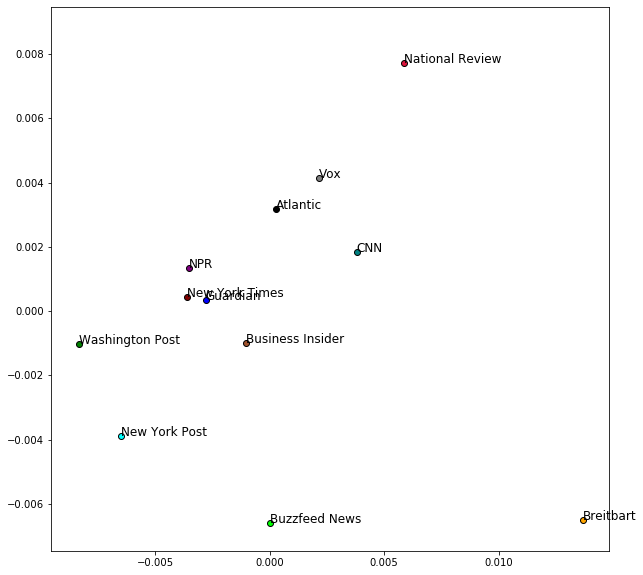

In [42]:
plot_PCA_2D(pcafeatures_topics, target=np.arange(12), target_names = topic_sensit_to_2d_df.iloc[:,6:].index)

In [48]:
news_categories_sentiment_df.head()

,id,title,date,content,year,month,publication,cleaned_content,subjectivity,neg,...,component_34,component_35,component_36,component_37,component_38,component_39,component_40,component_41,component_42,component_43
0,17283.0,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016.0,12.0,New York Times,washington — congressional republican have a n...,0.438163,0.108,...,0.00000,0.00000,0.0,0.00723,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,17284.0,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017.0,6.0,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,...,0.00089,0.00379,0.0,0.00434,0.00000,0.00000,0.00000,0.00218,0.00000,0.00000
2,17285.0,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017.0,1.0,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,...,0.00007,0.00000,0.0,0.00131,0.00000,0.06346,0.00000,0.00347,0.00000,0.02196
3,17286.0,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017.0,4.0,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,...,0.00000,0.00551,0.0,0.00453,0.00715,0.01353,0.00291,0.00000,0.00000,0.00000
4,17287.0,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017.0,1.0,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,...,0.00165,0.00408,0.0,0.00315,0.00000,0.00000,0.00239,0.00902,0.00194,0.00000


### Temporal Analysis of Topics

In [49]:
news_categories_sentiment_df['date_as_datetime'] = pd.to_datetime(news_categories_sentiment_df.date)

In [59]:
news_categories_sentiment_df = news_categories_sentiment_df.rename(columns = {'component_1':'people, life',
       'component_2': 'donuld trump', 'component_3':'united state',
       'component_4':'hillary clinton', 'component_5':'police, shooting',
         'component_6':'attack, syria', 'component_7':'company, business',
       'component_8':'sport', 'component_9':'court,supreme',
         'component_10':'student, college', 'component_11':'white house',
       'component_12':'republican, democrat, vote', 'component_13':'woman, march',
        'component_14':'barack obama', 'component_15':'family, life',
       'component_16':'fbi, comey', 'component_17':'film, tv',
       'component_18':'N/S carolina, military', 'component_19':'america, war, world',
       'component_20':'poll, vote, economy', 'component_21':'europe, british, vote',
         'component_22':'tax cut, reform', 'component_23':'russia, intelligence',
       'component_24':'black/white race, america', 'component_25':'heath care, coverage',
         'component_26':'book, writer', 'component_27':'breitbart, donald, radio',
       'component_28':'city, neighborhood',
        'component_30':'immigration, wall, illegal', 'component_29':'facebook, social medium',
'component_31':'muslim, ban',
       'component_32':'drug,criminal', 'component_33':'gun, violence',
       'component_34':'china, trade',
       'component_35':'car, model, road',
'component_36':'food, store, product',
'component_37':'million, market',
             'component_38':'news, reporter',
         'component_39':'los angeles, music', 'component_40':'tv series',
      'component_41':'research, university',
        'component_42':'twitter, trump',
'component_43':'water, florida, land, emergency'})

In [60]:
news_categories_sentiment_df.iloc[:,14:].head()

,"people, life",donuld trump,united state,hillary clinton,"police, shooting","attack, syria","company, business",sport,"court,supreme","student, college",...,"car, model, road","food, store, product","million, market","news, reporter","los angeles, music",tv series,"research, university","twitter, trump","water, florida, land, emergency",date_as_datetime
0,0.00000,0.01898,0.00180,0.00000,0.00000,0.00000,0.00000,0.00194,0.01664,0.00000,...,0.00000,0.0,0.00723,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2016-12-31
1,0.00679,0.00000,0.00037,0.00000,0.06307,0.00000,0.00000,0.00000,0.00567,0.00168,...,0.00379,0.0,0.00434,0.00000,0.00000,0.00000,0.00218,0.00000,0.00000,2017-06-19
2,0.00139,0.00000,0.01549,0.00000,0.00000,0.00078,0.00342,0.00000,0.00000,0.00831,...,0.00000,0.0,0.00131,0.00000,0.06346,0.00000,0.00347,0.00000,0.02196,2017-01-06
3,0.01207,0.00000,0.00000,0.00165,0.00208,0.00510,0.00000,0.01495,0.00741,0.00336,...,0.00551,0.0,0.00453,0.00715,0.01353,0.00291,0.00000,0.00000,0.00000,2017-04-10
4,0.00000,0.01599,0.01986,0.00000,0.00000,0.00218,0.00122,0.00069,0.00041,0.00000,...,0.00408,0.0,0.00315,0.00000,0.00000,0.00239,0.00902,0.00194,0.00000,2017-01-02


In [61]:
temp_analysis_groupby_date_df = news_categories_sentiment_df.iloc[:,14:].groupby(['date_as_datetime']).mean()

In [62]:
#temp_analysis_groupby_date_df = temp_analysis_groupby_date_df.drop(['article_length'],axis=1)

In [63]:
temp_analysis_groupby_date_df['popular_topic_of_day'] = temp_analysis_groupby_date_df.idxmax(axis=1)

In [64]:
temp_analysis_groupby_date_df['popular_topic_of_day'].unique()

array(['donuld trump', 'news, reporter', 'twitter, trump', 'woman, march',
       'million, market', 'facebook, social medium', 'book, writer',
       'hillary clinton', 'police, shooting', 'research, university',
       'water, florida, land, emergency', 'los angeles, music',
       'city, neighborhood', 'sport', 'russia, intelligence',
       'N/S carolina, military', 'gun, violence', 'company, business',
       'black/white race, america', 'white house', 'tax cut, reform',
       'court,supreme', 'tv series', 'family, life', 'film, tv',
       'heath care, coverage', 'china, trade', 'europe, british, vote',
       'america, war, world', 'food, store, product', 'united state'],
      dtype=object)

In [93]:
temp_analysis_groupby_date_df['2nd_highest'] = temp_analysis_groupby_date_df[['people, life', 'donuld trump', 'united state', 'hillary clinton',
       'police, shooting', 'attack, syria', 'company, business', 'sport',
       'court,supreme', 'student, college', 'white house',
       'republican, democrat, vote', 'woman, march', 'barack obama',
       'family, life', 'fbi, comey', 'film, tv', 'N/S carolina, military',
       'america, war, world', 'poll, vote, economy', 'europe, british, vote',
       'tax cut, reform', 'russia, intelligence', 'black/white race, america',
       'heath care, coverage', 'book, writer', 'breitbart, donald, radio',
       'city, neighborhood', 'facebook, social medium',
       'immigration, wall, illegal', 'muslim, ban', 'drug,criminal',
       'gun, violence', 'china, trade', 'car, model, road',
       'food, store, product', 'million, market', 'news, reporter',
       'los angeles, music', 'tv series', 'research, university',
       'twitter, trump', 'water, florida, land, emergency']].columns[temp_analysis_groupby_date_df[['people, life', 'donuld trump', 'united state', 'hillary clinton',
       'police, shooting', 'attack, syria', 'company, business', 'sport',
       'court,supreme', 'student, college', 'white house',
       'republican, democrat, vote', 'woman, march', 'barack obama',
       'family, life', 'fbi, comey', 'film, tv', 'N/S carolina, military',
       'america, war, world', 'poll, vote, economy', 'europe, british, vote',
       'tax cut, reform', 'russia, intelligence', 'black/white race, america',
       'heath care, coverage', 'book, writer', 'breitbart, donald, radio',
       'city, neighborhood', 'facebook, social medium',
       'immigration, wall, illegal', 'muslim, ban', 'drug,criminal',
       'gun, violence', 'china, trade', 'car, model, road',
       'food, store, product', 'million, market', 'news, reporter',
       'los angeles, music', 'tv series', 'research, university',
       'twitter, trump', 'water, florida, land, emergency']].values.argsort(1)[:,-2]]

In [94]:
temp_analysis_groupby_date_df

,"people, life",donuld trump,united state,hillary clinton,"police, shooting","attack, syria","company, business",sport,"court,supreme","student, college",...,"food, store, product","million, market","news, reporter","los angeles, music",tv series,"research, university","twitter, trump","water, florida, land, emergency",popular_topic_of_day,2nd_highest
date_as_datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.003556,0.007398,0.002423,0.005448,0.003752,0.001408,0.002703,0.002404,0.004713,0.002996,...,0.003162,0.004441,0.004363,0.004176,0.002171,0.004729,0.006692,0.002631,donuld trump,"twitter, trump"
2016-01-02,0.004358,0.007566,0.002061,0.005171,0.002865,0.001562,0.004738,0.002027,0.002728,0.001356,...,0.003858,0.007082,0.007994,0.003092,0.001339,0.005049,0.005612,0.004795,"news, reporter",donuld trump
2016-01-03,0.004901,0.008829,0.002952,0.004766,0.003935,0.001420,0.004255,0.002030,0.003184,0.001444,...,0.002487,0.005790,0.007336,0.003589,0.002329,0.004299,0.005671,0.004322,donuld trump,"news, reporter"
2016-01-04,0.004538,0.009516,0.002565,0.005765,0.002824,0.002168,0.003705,0.003195,0.002056,0.002454,...,0.003585,0.005120,0.006808,0.003497,0.002607,0.004833,0.007326,0.004138,donuld trump,"twitter, trump"
2016-01-05,0.004570,0.009549,0.002958,0.004645,0.003111,0.001729,0.004222,0.003158,0.002817,0.001418,...,0.004009,0.005759,0.007013,0.004665,0.002439,0.004066,0.007311,0.003823,donuld trump,"twitter, trump"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,0.005713,0.009278,0.002096,0.000674,0.003680,0.002598,0.003692,0.006134,0.005854,0.000606,...,0.002336,0.005461,0.003469,0.002612,0.004185,0.001355,0.004486,0.004201,"book, writer",donuld trump
2017-12-28,0.004621,0.008437,0.004463,0.000700,0.000765,0.000603,0.007601,0.003000,0.002437,0.001696,...,0.002168,0.007866,0.011682,0.017651,0.003460,0.003911,0.004537,0.003591,"los angeles, music","news, reporter"
2017-12-29,0.003992,0.007456,0.003017,0.000334,0.002828,0.000992,0.001992,0.012197,0.001275,0.004531,...,0.000279,0.004937,0.004176,0.003910,0.004259,0.006775,0.001742,0.007547,sport,"film, tv"


In [65]:
temp_analysis_groupby_date_df.iloc[:31].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()

popular_topic_of_day
donuld trump       27
million, market     1
news, reporter      1
twitter, trump      1
woman, march        1
Name: date_as_datetime, dtype: int64

In [114]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[:31].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'jan16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[:31].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'jan16_2nd_highest'})
jan16=pd.merge(a,b, on = 'topic', how = 'outer')
jan16

,topic,jan16_popular_topic_of_day,jan16_2nd_highest
0,donuld trump,27.0,3.0
1,"million, market",1.0,NaN
2,"news, reporter",1.0,11.0
3,"twitter, trump",1.0,8.0
4,"woman, march",1.0,NaN
5,hillary clinton,NaN,6.0
6,"poll, vote, economy",NaN,1.0
7,"research, university",NaN,2.0


In [115]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[31:60].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'feb16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[31:60].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'feb16_2nd_highest'})
feb16=pd.merge(a,b, on = 'topic', how = 'outer')
feb16

,topic,feb16_popular_topic_of_day,feb16_2nd_highest
0,donuld trump,28.0,1
1,"news, reporter",1.0,20
2,hillary clinton,NaN,3
3,"los angeles, music",NaN,1
4,"research, university",NaN,1
5,"twitter, trump",NaN,2
6,"water, florida, land, emergency",NaN,1


In [116]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[60:91].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'mar16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[60:91].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'mar16_2nd_highest'})
mar16=pd.merge(a,b, on = 'topic', how = 'outer')
mar16

,topic,mar16_popular_topic_of_day,mar16_2nd_highest
0,donuld trump,28.0,1
1,"facebook, social medium",1.0,1
2,"news, reporter",2.0,13
3,"city, neighborhood",NaN,1
4,"gun, violence",NaN,2
5,hillary clinton,NaN,3
6,"million, market",NaN,5
7,"poll, vote, economy",NaN,1
8,"research, university",NaN,1
9,"twitter, trump",NaN,3


In [117]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[91:121].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'apr16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[91:121].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'apr16_2nd_highest'})
apr16=pd.merge(a,b, on = 'topic', how = 'outer')
apr16

,topic,apr16_popular_topic_of_day,apr16_2nd_highest
0,donuld trump,29.0,1
1,"news, reporter",1.0,12
2,hillary clinton,NaN,7
3,"los angeles, music",NaN,1
4,"million, market",NaN,6
5,"twitter, trump",NaN,2
6,"water, florida, land, emergency",NaN,1


In [118]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[121:152].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'may16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[121:152].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'may16_2nd_highest'})
may16=pd.merge(a,b, on = 'topic', how = 'outer')
may16

,topic,may16_popular_topic_of_day,may16_2nd_highest
0,"book, writer",1.0,NaN
1,donuld trump,29.0,1.0
2,hillary clinton,1.0,13.0
3,"million, market",NaN,6.0
4,"news, reporter",NaN,2.0
5,"poll, vote, economy",NaN,1.0
6,"research, university",NaN,3.0
7,"twitter, trump",NaN,5.0


In [119]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[152:182].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'jun16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[152:182].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'jun16_2nd_highest'})
jun16=pd.merge(a,b, on = 'topic', how = 'outer')
jun16

,topic,jun16_popular_topic_of_day,jun16_2nd_highest
0,donuld trump,30.0,NaN
1,hillary clinton,NaN,10.0
2,"million, market",NaN,7.0
3,"news, reporter",NaN,8.0
4,"research, university",NaN,3.0
5,"twitter, trump",NaN,2.0


In [120]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[182:213].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'jul16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[182:213].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'jul16_2nd_highest'})
jul16=pd.merge(a,b, on = 'topic', how = 'outer')
jul16

,topic,jul16_popular_topic_of_day,jul16_2nd_highest
0,donuld trump,29.0,1
1,"news, reporter",1.0,4
2,"police, shooting",1.0,2
3,"gun, violence",NaN,1
4,hillary clinton,NaN,17
5,"million, market",NaN,1
6,"research, university",NaN,1
7,"twitter, trump",NaN,4


In [121]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[213:244].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'aug16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[213:244].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'aug16_2nd_highest'})
aug16=pd.merge(a,b, on = 'topic', how = 'outer')
aug16

,topic,aug16_popular_topic_of_day,aug16_2nd_highest
0,donuld trump,31.0,NaN
1,hillary clinton,NaN,11.0
2,"million, market",NaN,1.0
3,"news, reporter",NaN,14.0
4,"research, university",NaN,1.0
5,"twitter, trump",NaN,2.0
6,"water, florida, land, emergency",NaN,2.0


In [122]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[244:274].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'sep16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[244:274].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'sep16_2nd_highest'})
sep16=pd.merge(a,b, on = 'topic', how = 'outer')
sep16

,topic,sep16_popular_topic_of_day,sep16_2nd_highest
0,donuld trump,30.0,NaN
1,hillary clinton,NaN,16.0
2,"million, market",NaN,2.0
3,"news, reporter",NaN,6.0
4,"research, university",NaN,3.0
5,"twitter, trump",NaN,3.0


In [123]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[274:305].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'oct16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[274:305].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'oct16_2nd_highest'})
oct16=pd.merge(a,b, on = 'topic', how = 'outer')
oct16

,topic,oct16_popular_topic_of_day,oct16_2nd_highest
0,donuld trump,31.0,NaN
1,hillary clinton,NaN,2.0
2,"million, market",NaN,7.0
3,"news, reporter",NaN,13.0
4,"research, university",NaN,6.0
5,"twitter, trump",NaN,3.0


In [124]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[305:335].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'nov16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[305:335].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'nov16_2nd_highest'})
nov16=pd.merge(a,b, on = 'topic', how = 'outer')
nov16

,topic,nov16_popular_topic_of_day,nov16_2nd_highest
0,donuld trump,30.0,NaN
1,"film, tv",NaN,1.0
2,"million, market",NaN,2.0
3,"news, reporter",NaN,22.0
4,"research, university",NaN,1.0
5,"twitter, trump",NaN,4.0


In [125]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[335:366].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'dec16_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[335:366].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'dec16_2nd_highest'})
dec16=pd.merge(a,b, on = 'topic', how = 'outer')
dec16

,topic,dec16_popular_topic_of_day,dec16_2nd_highest
0,donuld trump,31.0,NaN
1,"america, war, world",NaN,1.0
2,"court,supreme",NaN,4.0
3,"million, market",NaN,6.0
4,"news, reporter",NaN,14.0
5,sport,NaN,1.0
6,"twitter, trump",NaN,4.0
7,"water, florida, land, emergency",NaN,1.0


In [126]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[366:397].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'jan17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[366:397].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'jan17_2nd_highest'})
jan17=pd.merge(a,b, on = 'topic', how = 'outer')
jan17

,topic,jan17_popular_topic_of_day,jan17_2nd_highest
0,donuld trump,31.0,NaN
1,"court,supreme",NaN,1.0
2,"million, market",NaN,5.0
3,"news, reporter",NaN,16.0
4,"research, university",NaN,3.0
5,"russia, intelligence",NaN,1.0
6,"twitter, trump",NaN,4.0
7,"water, florida, land, emergency",NaN,1.0


In [127]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[397:425].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'feb17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[397:425].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'feb17_2nd_highest'})
feb17=pd.merge(a,b, on = 'topic', how = 'outer')
feb17

,topic,feb17_popular_topic_of_day,feb17_2nd_highest
0,donuld trump,28.0,NaN
1,"million, market",NaN,7.0
2,"news, reporter",NaN,20.0
3,"twitter, trump",NaN,1.0


In [128]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[425:456].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'mar17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[425:456].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'mar17_2nd_highest'})
mar17=pd.merge(a,b, on = 'topic', how = 'outer')
mar17

,topic,mar17_popular_topic_of_day,mar17_2nd_highest
0,donuld trump,31.0,NaN
1,"million, market",NaN,15.0
2,"news, reporter",NaN,12.0
3,"research, university",NaN,3.0
4,"twitter, trump",NaN,1.0


In [129]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[456:486].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'apr17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[456:486].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'apr17_2nd_highest'})
apr17=pd.merge(a,b, on = 'topic', how = 'outer')
apr17

,topic,apr17_popular_topic_of_day,apr17_2nd_highest
0,donuld trump,30.0,NaN
1,"million, market",NaN,10.0
2,"news, reporter",NaN,10.0
3,"research, university",NaN,7.0
4,"twitter, trump",NaN,2.0
5,"water, florida, land, emergency",NaN,1.0


In [130]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[486:517].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'may17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[486:517].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'may17_2nd_highest'})
may17=pd.merge(a,b, on = 'topic', how = 'outer')
may17

,topic,may17_popular_topic_of_day,may17_2nd_highest
0,donuld trump,31.0,NaN
1,"fbi, comey",NaN,3.0
2,"million, market",NaN,5.0
3,"news, reporter",NaN,6.0
4,"twitter, trump",NaN,15.0
5,"water, florida, land, emergency",NaN,1.0
6,white house,NaN,1.0


In [131]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[517:547].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'jun17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[517:547].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'jun17_2nd_highest'})
jun17=pd.merge(a,b, on = 'topic', how = 'outer')
jun17

,topic,jun17_popular_topic_of_day,jun17_2nd_highest
0,"city, neighborhood",1.0,NaN
1,donuld trump,24.0,2.0
2,"los angeles, music",1.0,NaN
3,"million, market",2.0,7.0
4,"research, university",1.0,2.0
5,"water, florida, land, emergency",1.0,2.0
6,"book, writer",NaN,2.0
7,"news, reporter",NaN,4.0
8,"people, life",NaN,1.0
9,sport,NaN,1.0


In [132]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[547:578].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'jul17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[547:578].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'jul17_2nd_highest'})
jul17=pd.merge(a,b, on = 'topic', how = 'outer')
jul17

,topic,jul17_popular_topic_of_day,jul17_2nd_highest
0,"N/S carolina, military",1.0,1.0
1,"black/white race, america",1.0,NaN
2,"book, writer",4.0,1.0
3,"city, neighborhood",3.0,3.0
4,"company, business",3.0,NaN
5,"court,supreme",1.0,NaN
6,donuld trump,1.0,9.0
7,"gun, violence",1.0,1.0
8,"los angeles, music",4.0,1.0
9,"police, shooting",1.0,2.0


In [133]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[578:609].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'aug17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[578:609].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'aug17_2nd_highest'})
aug17=pd.merge(a,b, on = 'topic', how = 'outer')
aug17

,topic,aug17_popular_topic_of_day,aug17_2nd_highest
0,"black/white race, america",1.0,1.0
1,"china, trade",1.0,2.0
2,"city, neighborhood",4.0,NaN
3,donuld trump,4.0,NaN
4,"family, life",1.0,3.0
5,"film, tv",1.0,1.0
6,"heath care, coverage",1.0,NaN
7,"los angeles, music",6.0,3.0
8,"million, market",2.0,NaN
9,"news, reporter",1.0,NaN


In [134]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[609:639].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'sep17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[609:639].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'sep17_2nd_highest'})
sep17=pd.merge(a,b, on = 'topic', how = 'outer')
sep17

,topic,sep17_popular_topic_of_day,sep17_2nd_highest
0,"america, war, world",1.0,NaN
1,"book, writer",1.0,1.0
2,"china, trade",1.0,NaN
3,"court,supreme",2.0,3.0
4,donuld trump,3.0,3.0
5,"europe, british, vote",2.0,1.0
6,"family, life",1.0,NaN
7,"film, tv",1.0,1.0
8,"los angeles, music",6.0,NaN
9,"million, market",1.0,6.0


In [135]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[639:670].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'oct17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[639:670].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'oct17_2nd_highest'})
oct17=pd.merge(a,b, on = 'topic', how = 'outer')
oct17

,topic,oct17_popular_topic_of_day,oct17_2nd_highest
0,"black/white race, america",1.0,NaN
1,"book, writer",6.0,3.0
2,"china, trade",1.0,1.0
3,"city, neighborhood",1.0,5.0
4,donuld trump,4.0,2.0
5,"facebook, social medium",2.0,NaN
6,"film, tv",1.0,NaN
7,"food, store, product",1.0,NaN
8,"los angeles, music",6.0,1.0
9,"million, market",2.0,5.0


In [136]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[670:700].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'nov17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[670:700].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'nov17_2nd_highest'})
nov17=pd.merge(a,b, on = 'topic', how = 'outer')
nov17

,topic,nov17_popular_topic_of_day,nov17_2nd_highest
0,"N/S carolina, military",1.0,2.0
1,"book, writer",3.0,2.0
2,"city, neighborhood",1.0,2.0
3,"company, business",1.0,NaN
4,"court,supreme",3.0,1.0
5,donuld trump,2.0,3.0
6,"los angeles, music",5.0,2.0
7,"million, market",4.0,1.0
8,"police, shooting",1.0,2.0
9,"research, university",3.0,3.0


In [137]:
a = pd.DataFrame(temp_analysis_groupby_date_df.iloc[700:731].reset_index().groupby(['popular_topic_of_day']).date_as_datetime.count()).reset_index()
a = a.rename(columns={'popular_topic_of_day':'topic','date_as_datetime':'dec17_popular_topic_of_day'})
b=pd.DataFrame(temp_analysis_groupby_date_df.iloc[700:731].reset_index().groupby(['2nd_highest']).date_as_datetime.count())
b = b.reset_index()
b = b.rename(columns={'2nd_highest':'topic','date_as_datetime':'dec17_2nd_highest'})
dec17=pd.merge(a,b, on = 'topic', how = 'outer')
dec17

,topic,dec17_popular_topic_of_day,dec17_2nd_highest
0,"book, writer",4.0,3.0
1,"city, neighborhood",2.0,NaN
2,"court,supreme",1.0,NaN
3,donuld trump,5.0,8.0
4,"family, life",1.0,1.0
5,"film, tv",1.0,3.0
6,"los angeles, music",9.0,2.0
7,"million, market",2.0,1.0
8,"news, reporter",2.0,1.0
9,"police, shooting",1.0,1.0


In [139]:
from functools import reduce

In [140]:
dfs = [jan16,feb16,mar16,apr16,may16,jun16,jul16,aug16,sep16,oct16,nov16,dec16,jan17,feb17,mar17,apr17,may17,jun17,jul17,aug17,sep17,oct17,nov17,dec17]
nan_value = 0
# solution 1 (fast)
result = reduce(lambda left,right: pd.merge(left, right,
                                              on='topic',
                                              how='outer'),
                  dfs).fillna(nan_value)

Use result df in Tableu to visualize topic changes overtime

In [141]:
result

,topic,jan16_popular_topic_of_day,jan16_2nd_highest,feb16_popular_topic_of_day,feb16_2nd_highest,mar16_popular_topic_of_day,mar16_2nd_highest,apr16_popular_topic_of_day,apr16_2nd_highest,may16_popular_topic_of_day,...,aug17_popular_topic_of_day,aug17_2nd_highest,sep17_popular_topic_of_day,sep17_2nd_highest,oct17_popular_topic_of_day,oct17_2nd_highest,nov17_popular_topic_of_day,nov17_2nd_highest,dec17_popular_topic_of_day,dec17_2nd_highest
0,donuld trump,27.0,3.0,28.0,1.0,28.0,1.0,29.0,1.0,29.0,...,4.0,0.0,3.0,3.0,4.0,2.0,2.0,3.0,5.0,8.0
1,"million, market",1.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,0.0,...,2.0,0.0,1.0,6.0,2.0,5.0,4.0,1.0,2.0,1.0
2,"news, reporter",1.0,11.0,1.0,20.0,2.0,13.0,1.0,12.0,0.0,...,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
3,"twitter, trump",1.0,8.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"woman, march",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,hillary clinton,0.0,6.0,0.0,3.0,0.0,3.0,0.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"poll, vote, economy",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
7,"research, university",0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,2.0,2.0,2.0,0.0,3.0,3.0,0.0,2.0
8,"los angeles, music",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,6.0,3.0,6.0,0.0,6.0,1.0,5.0,2.0,9.0,2.0
9,"water, florida, land, emergency",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,2.0,1.0,0.0,0.0,2.0,3.0,2.0,0.0,1.0


In [143]:
news_categories_sentiment_df.head()

,id,title,date,content,year,month,publication,cleaned_content,subjectivity,neg,...,"car, model, road","food, store, product","million, market","news, reporter","los angeles, music",tv series,"research, university","twitter, trump","water, florida, land, emergency",date_as_datetime
0,17283.0,House Republicans Fret About Winning Their Hea...,2016-12-31,WASHINGTON — Congressional Republicans have a ...,2016.0,12.0,New York Times,washington — congressional republican have a n...,0.438163,0.108,...,0.00000,0.0,0.00723,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2016-12-31
1,17284.0,Rift Between Officers and Residents as Killing...,2017-06-19,"After the bullet shells get counted, the blood...",2017.0,6.0,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,...,0.00379,0.0,0.00434,0.00000,0.00000,0.00000,0.00218,0.00000,0.00000,2017-06-19
2,17285.0,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri...",2017.0,1.0,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,...,0.00000,0.0,0.00131,0.00000,0.06346,0.00000,0.00347,0.00000,0.02196,2017-01-06
3,17286.0,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",2017-04-10,"Death may be the great equalizer, but it isn’t...",2017.0,4.0,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,...,0.00551,0.0,0.00453,0.00715,0.01353,0.00291,0.00000,0.00000,0.00000,2017-04-10
4,17287.0,Kim Jong-un Says North Korea Is Preparing to T...,2017-01-02,"SEOUL, South Korea — North Korea’s leader, Kim...",2017.0,1.0,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,...,0.00408,0.0,0.00315,0.00000,0.00000,0.00239,0.00902,0.00194,0.00000,2017-01-02


### Split into Train and Test sets

In [142]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split


In [145]:
news_for_supervised_df = news_categories_sentiment_df.drop(['title','year','month', 'date'], axis = 1)

In [146]:
#news_for_supervised_df['article_length'] = news_for_supervised_df.cleaned_content.str.split().apply(len)

In [147]:
news_for_supervised_df = news_for_supervised_df.drop(['id', 'content', 'date_as_datetime'], axis = 1)

In [148]:
news_for_supervised_df

,publication,cleaned_content,subjectivity,neg,neu,pos,compound,num_nouns,"people, life",donuld trump,...,"china, trade","car, model, road","food, store, product","million, market","news, reporter","los angeles, music",tv series,"research, university","twitter, trump","water, florida, land, emergency"
0,New York Times,washington — congressional republican have a n...,0.438163,0.108,0.774,0.117,0.6933,289.0,0.00000,0.01898,...,0.00000,0.00000,0.0,0.00723,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,New York Times,after the bullet shell get counted the blood d...,0.379264,0.163,0.765,0.072,-1.0000,1574.0,0.00679,0.00000,...,0.00089,0.00379,0.0,0.00434,0.00000,0.00000,0.00000,0.00218,0.00000,0.00000
2,New York Times,when walt disney’s “bambi” opened in critic pr...,0.427479,0.077,0.823,0.100,0.9963,828.0,0.00139,0.00000,...,0.00007,0.00000,0.0,0.00131,0.00000,0.06346,0.00000,0.00347,0.00000,0.02196
3,New York Times,death may be the great equalizer but it isn’t ...,0.448641,0.121,0.757,0.123,-0.1786,736.0,0.01207,0.00000,...,0.00000,0.00551,0.0,0.00453,0.00715,0.01353,0.00291,0.00000,0.00000,0.00000
4,New York Times,seoul south korea — north korea’s leader kim j...,0.537121,0.043,0.845,0.112,0.9938,219.0,0.00000,0.01599,...,0.00165,0.00408,0.0,0.00315,0.00000,0.00000,0.00239,0.00902,0.00194,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154974,New York Times,rick rojas is a reporter for the time who grew...,0.505016,0.038,0.893,0.069,0.9767,197.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154975,New York Times,london — you might call it a triumphal return ...,0.455582,0.041,0.834,0.125,0.9984,443.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154976,New York Times,san francisco — airbnb agreed on monday to set...,0.420384,0.035,0.846,0.119,0.9954,257.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154977,New York Times,in the band’s popular song “the night they dro...,0.420050,0.172,0.695,0.133,-0.9989,568.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [311]:
news_for_supervised_df.to_csv('news_for_supervised_df.csv')

In [151]:
news_for_supervised_df = news_for_supervised_df[news_for_supervised_df.publication.notnull()]

In [152]:
news_for_supervised_df.publication.unique()

array(['New York Times', 'Breitbart', 'CNN', 'Business Insider',
       'Atlantic', 'Buzzfeed News', 'National Review', 'New York Post',
       'Guardian', 'NPR', 'Vox', 'Washington Post'], dtype=object)

In [153]:
X, y = news_for_supervised_df[['cleaned_content', 'subjectivity', 'compound', 'neg',
       'neu', 'pos', 'num_nouns']], news_for_supervised_df.publication

In [154]:
# map y to categories instead of words
y_cat = y.map({'Washington Post': 1,'Vox':2,'New York Times':3, 'Breitbart':4,
               'CNN':5, 'Business Insider':6,'Atlantic':7,'Buzzfeed News':8,
      'National Review':9,'New York Post':10,'Guardian':11,'NPR':12})


In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,test_size = 0.3, random_state = 2, stratify = y, shuffle = True)

# X_test, y_test will be the hold out for last step

In [156]:
#news_publication_content_df = pd.concat([X_train, y_train], axis = 1)

#news_publication_content_df.head()
X_train.shape

(99390, 7)

In [157]:
y_train.value_counts()

3     17619
4     16601
10    11928
12     8277
1      7759
8      7452
11     6039
5      5553
6      5275
7      5152
9      4318
2      3417
Name: publication, dtype: int64

In [158]:
X_train

,cleaned_content,subjectivity,compound,neg,neu,pos,num_nouns
2014,good morning want to get california today by e...,0.424442,-0.9095,0.115,0.781,0.104,334.0
50215,i want to receive update from partner and spon...,0.356176,-0.7013,0.109,0.786,0.104,232.0
38326,cnnhillary clinton donald trump gary johnson a...,0.433694,0.9830,0.020,0.896,0.084,172.0
61379,last week a photo went viral of four college s...,0.310969,0.9901,0.045,0.819,0.136,121.0
24935,san antonio texas police officer arrested a lo...,0.342714,-0.3130,0.060,0.876,0.063,280.0
...,...,...,...,...,...,...,...
92804,after surviving multiple bomb attack while tra...,0.449087,-0.9956,0.130,0.787,0.082,287.0
101746,tiny cluster of human brain cell grown in a pe...,0.461193,0.8753,0.061,0.864,0.074,248.0
123715,what do we really know about the research on w...,0.434641,-0.9997,0.192,0.728,0.079,469.0
53804,for u to continue writing great story we need ...,0.308041,-0.6226,0.099,0.816,0.085,123.0


### Stratified KFold Cross Validation 

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
#from imblearn.over_sampling import RandomOvfrom sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifiererSampler
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB 

In [ ]:
kf_stratified = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)


In [70]:

for n_estimators in np.arange(10,60,20):

    dt_val_f1_score_list = []
    dt_val_accuracy_list = []
    dt_val_recall_list = []
    dt_val_precision_list = []

    dt_tr_f1_score_list = []
    dt_tr_accuracy_list = []
    dt_tr_recall_list = []
    dt_tr_precision_list = []

    for train_ind, val_index in kf_stratified.split(X_train, y_train):
        X_tr, X_vl = X_train.iloc[train_ind], X_train.iloc[val_index]
        y_tr, y_vl = y_train.iloc[train_ind], y_train.iloc[val_index]

        # TFIDF counter vectorizer fit_trans X_train
        # Only transform on y_train
        cv_tfidf_nmf_cv = TfidfVectorizer(ngram_range=(1,2),stop_words = stop_words, min_df = 0.05, max_df = 0.9)
        X_tr_count_vec = cv_tfidf_nmf_cv.fit_transform(X_tr.cleaned_content)
        X_vl_count_vec = cv_tfidf_nmf_cv.transform(X_vl.cleaned_content)

        nmf_model_tfidf_cv = NMF(43)
        X_tr_doc_topic = nmf_model_tfidf_cv.fit_transform(X_tr_count_vec)
        X_vl_doc_topic = nmf_model_tfidf_cv.transform(X_vl_count_vec)

        Vt_tr = pd.DataFrame(X_tr_doc_topic.round(5),
                 columns = ["component_1","component_2", "component_3", "component_4",
                  "component_5","component_6","component_7", "component_8", 
                  "component_9","component_10","component_11","component_12",
                  "component_13", "component_14","component_15","component_16",
                  "component_17", "component_18", "component_19","component_20",
                 "component_21","component_22", "component_23", "component_24",
                  "component_25", "component_26","component_27", "component_28", 
                  "component_29","component_30","component_31","component_32",
                  "component_33", "component_34",
                  "component_35", "component_36","component_37", "component_38", 
                  "component_39","component_40","component_41","component_42", "component_43"])
        Vt_vl = pd.DataFrame(X_vl_doc_topic.round(5),
                 columns = ["component_1","component_2", "component_3", "component_4",
                  "component_5","component_6","component_7", "component_8", 
                  "component_9","component_10","component_11","component_12",
                  "component_13", "component_14","component_15","component_16",
                  "component_17", "component_18", "component_19","component_20",
                 "component_21","component_22", "component_23", "component_24",
                  "component_25", "component_26","component_27", "component_28", 
                  "component_29","component_30","component_31","component_32",
                  "component_33", "component_34",
                  "component_35", "component_36","component_37", "component_38", 
                  "component_39","component_40","component_41","component_42", "component_43"])

        new_X_tr = pd.concat([X_tr.drop(['cleaned_content'],axis=1).reset_index(), Vt_tr], axis = 1)
        new_X_vl = pd.concat([X_vl.drop(['cleaned_content'],axis=1).reset_index(), Vt_vl], axis = 1)

        #ros = RandomOverSampler(random_state=1)
        #X_resampled, y_resampled = ros.fit_sample(X_tr_scaled, y_tr)

        # Train
        #dt_model = DecisionTreeClassifier(max_depth=max_d)
        #dt_model = GaussianNB()
        dt_model = RandomForestClassifier(n_estimators = 45, max_depth = 11)
        dt_model.fit(new_X_tr, y_tr)
        train_predicted = dt_model.predict(new_X_tr)

        val_predicted = dt_model.predict(new_X_vl)

        dt_tr_accuracy_list.append(accuracy_score(y_tr, train_predicted))
        dt_tr_recall_list.append(recall_score(y_tr, train_predicted,average = 'macro'))
        dt_tr_precision_list.append(precision_score(y_tr, train_predicted, average ='macro'))
        #dt_tr_f1_score_list.append(f1_score(y_tr, train_predicted))

        dt_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
        dt_val_recall_list.append(recall_score(y_vl, val_predicted,average='macro'))
        dt_val_precision_list.append(precision_score(y_vl, val_predicted,average='macro'))
        #dt_val_f1_score_list.append(f1_score(y_vl, val_predicted))

    print('Tree Depth: max_d = ', max_d)
    dt_tr_mean_accuracy = sum(dt_tr_accuracy_list)/len(dt_tr_accuracy_list)
    dt_tr_mean_precision = sum(dt_tr_precision_list)/len(dt_tr_precision_list)
    dt_tr_mean_recall = sum(dt_tr_recall_list)/len(dt_tr_recall_list)
    #dt_tr_mean_f1 = sum(dt_tr_f1_score_list)/len(dt_tr_f1_score_list)

    dt_vl_mean_accuracy = sum(dt_val_accuracy_list)/len(dt_val_accuracy_list)
    dt_vl_mean_precision = sum(dt_val_precision_list)/len(dt_val_precision_list)
    dt_vl_mean_recall = sum(dt_val_recall_list)/len(dt_val_recall_list)
    #dt_vl_mean_f1 = sum(dt_val_f1_score_list)/len(dt_val_f1_score_list)
    print('Training Mean scores        Validation Mean Scores')
    print(dt_tr_mean_accuracy,dt_vl_mean_accuracy)
    print(dt_tr_mean_precision,dt_vl_mean_precision)
    print(dt_tr_mean_recall,dt_vl_mean_recall)
    #print(dt_tr_mean_f1,dt_vl_mean_f1)





Tree Depth: max_d =  35
Training Mean scores        Validation Mean Scores
0.867798543284484 0.8147904069510417
0.8752902602783282 0.8151322897818392
0.8033410307193852 0.7301102002979775
Tree Depth: max_d =  35
Training Mean scores        Validation Mean Scores
0.879092675273082 0.8323067629654067
0.88799691318471 0.837500046118584
0.8179563936464795 0.7530283744953118
Tree Depth: max_d =  35
Training Mean scores        Validation Mean Scores
0.8647751351187286 0.8146899264838229
0.8704871134582124 0.8127793676229893
0.7986520973203725 0.7296432024627348


In [72]:
cv_tfidf_nmf_cv = TfidfVectorizer(ngram_range=(1,2),stop_words = stop_words, min_df = 0.05, max_df = 0.9)
X_tr_count_vec = cv_tfidf_nmf_cv.fit_transform(X_train.cleaned_content)
X_ts_count_vec = cv_tfidf_nmf_cv.transform(X_test.cleaned_content)

nmf_model_tfidf_cv = NMF(43)
X_train_doc_topic = nmf_model_tfidf_cv.fit_transform(X_tr_count_vec)
X_test_doc_topic = nmf_model_tfidf_cv.transform(X_ts_count_vec)

Vt_train = pd.DataFrame(X_train_doc_topic.round(5),
         columns = ["component_1","component_2", "component_3", "component_4",
          "component_5","component_6","component_7", "component_8", 
          "component_9","component_10","component_11","component_12",
          "component_13", "component_14","component_15","component_16",
          "component_17", "component_18", "component_19","component_20",
         "component_21","component_22", "component_23", "component_24",
          "component_25", "component_26","component_27", "component_28", 
          "component_29","component_30","component_31","component_32",
          "component_33", "component_34",
          "component_35", "component_36","component_37", "component_38", 
          "component_39","component_40","component_41","component_42", "component_43"])
Vt_test = pd.DataFrame(X_test_doc_topic.round(5),
         columns = ["component_1","component_2", "component_3", "component_4",
          "component_5","component_6","component_7", "component_8", 
          "component_9","component_10","component_11","component_12",
          "component_13", "component_14","component_15","component_16",
          "component_17", "component_18", "component_19","component_20",
         "component_21","component_22", "component_23", "component_24",
          "component_25", "component_26","component_27", "component_28", 
          "component_29","component_30","component_31","component_32",
          "component_33", "component_34",
          "component_35", "component_36","component_37", "component_38", 
          "component_39","component_40","component_41","component_42", "component_43"])

new_X_train = pd.concat([X_train.drop(['cleaned_content'],axis=1).reset_index(), Vt_train], axis = 1)
new_X_test = pd.concat([X_test.drop(['cleaned_content'],axis=1).reset_index(), Vt_test], axis = 1)

dt_model = RandomForestClassifier(n_estimators = 30, max_depth = 11)
dt_model.fit(new_X_train, y_train)
train_predicted = dt_model.predict(new_X_train)

test_predicted = dt_model.predict(new_X_test)

print('Train:')
print(accuracy_score(y_train, train_predicted))
print(recall_score(y_train, train_predicted,average = 'macro'))
print(precision_score(y_train, train_predicted,average = 'macro'))
print('Test:')
print(accuracy_score(y_test, test_predicted))
print(recall_score(y_test, test_predicted, average='macro'))
print(precision_score(y_test, test_predicted, average='macro'))

Train:
0.833967199919509
0.7585822307848072
0.8556360356191393
Test:
0.7985773646031411
0.7106756924832119
0.8140296090252882


Calculate precision and recall manually